## Has Seattle seen a reduction in collisions from reduced  speed limits?

This notebook examines the impact of reduced speed limits in central Seattle on the number of collisions and collision related injuries.

This notebook will leverage a Python package called CausalImpact, developed by Google, to investigate whether there was statistically significant drop in collisions or reduction in injuries after speed limits in Central Seattle were reduced in October of 2016.

https://google.github.io/CausalImpact/CausalImpact.html

#### Step 0: Import packages

In [1]:
#First we'll add another directory to paths list so we can import our package render_stats
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
from causalimpact import CausalImpact

In [3]:
#Render_stats will be used to perform most of the data cleaning in this project.
import wa_collisions.render_stats as render_stats

#### Step 1: Import data

First, let's read in the Seattle collisions data. We'll use data that already has collisions assigned to a neighborhood, however this function can also add a neighorhood if one has not been assigned.

In [31]:
file_path = "../wa_collisions/data/Collisions_With_Neighborhoods.csv"
data = render_stats.read_collision_with_neighborhoods(file_path, contains_neighborhood=True)

#### Step 2: Data clean-up and visualization

First, we'll identify neighborhoods where speed limit changed and those where it didn't. Based on looking at the boundaries of these neighborhoods we see that the boundaries are similar those shown in this report: http://www.seattle.gov/Documents/Departments/beSuperSafe/VZ_2017_Progress_Report.pdf![image.png](attachment:image.png)

We will assume all neighborhoods outside of this core group did not have their speed limits changed in October 2016.

After determining this list, we will call a function which pivots that data by the number of collisions per day in neighbhorhoods where speed limits changed and those where they didn't. These can be thought of as "control" and "treatment" groups.

In [32]:
speed_limit_nbrhood = ['Atlantic','Pike-Market', 'Belltown', 'International District',
       'Central Business District', 'First Hill', 'Yesler Terrace',
       'Pioneer Square', 'Interbay','Mann','Minor']

In [33]:
daily_collision_count = render_stats.pivot_by_treatment(input_frame=data, treatment_list=speed_limit_nbrhood, control_list=None
                       , neighborhood_path='../wa_collisions/data/Neighborhoods/Neighborhoods.json'
                       , agg_by=None, resample_by='D')

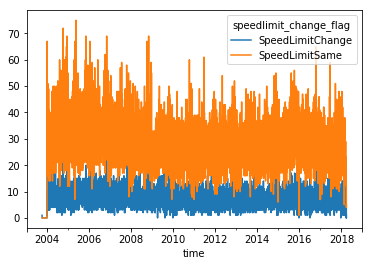

In [34]:
daily_collision_count.plot()

In [35]:
daily_collision_count.corr()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
speedlimit_change_flag,,
SpeedLimitChange,1.000000,0.452595
SpeedLimitSame,0.452595,1.000000


Plotting this data, we see that is quite noisy and events are not highly correlated. This violates our assumption that control and treatment are similar except for the change in speed limits.

What happens if we aggregate the data by month?

In [36]:
monthly_collision_count = render_stats.pivot_by_treatment(input_frame=data, treatment_list=speed_limit_nbrhood, control_list=None
                       , neighborhood_path='../wa_collisions/data/Neighborhoods/Neighborhoods.json'
                       , agg_by=None, resample_by='M')

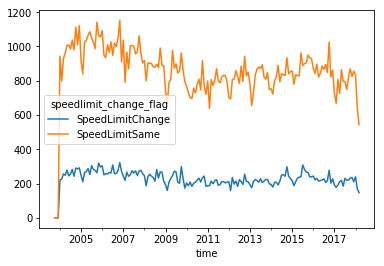

In [37]:
monthly_collision_count.plot()

In [38]:
monthly_collision_count.corr()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
speedlimit_change_flag,,
SpeedLimitChange,1.000000,0.909373
SpeedLimitSame,0.909373,1.000000


That's better!

Looking at the plot, we see that there appears to be a slight drop in the number of collisions in 2017, but it's pretty hard to tell. It also looks like there is a similar drop in neigborhoods where speed limits are not changed. Let's run the data through Causal Impact for a closer look.

#### Step 3: Analysis of collision counts

First, we need to find the date range before and after the speed limit change.

In [39]:
date_ranges = render_stats.find_period_ranges(monthly_collision_count, transition_date="2016-10-01")
print('pre:', date_ranges[0])
print('post:', date_ranges[1])

pre: ['2003-10-31', '2016-09-30']
post: ['2016-10-31', '2018-03-31']


Now, let's perform the analysis

In [40]:
impact_collision_count = CausalImpact(monthly_collision_count, date_ranges[0], date_ranges[1])
impact_collision_count.run()

In [41]:
impact_collision_count.summary()

                         Average       Cumulative
Actual                       210             3793
Predicted                    211             3798
95% CI                [172, 249]     [3103, 4494]
                                                 
Absolute Effect                0               -5
95% CI                 [38, -38]      [689, -701]
                                                 
Relative Effect            -0.1%            -0.1%
95% CI           [18.2%, -18.5%]  [18.2%, -18.5%]


Interesting. The results indicate there were 5 fewer collisions than would have been predicted based on a counterfactual. This is a -0.1% drop.

This result is definitely not statistically significant.

Let's plot the data for a closer look.

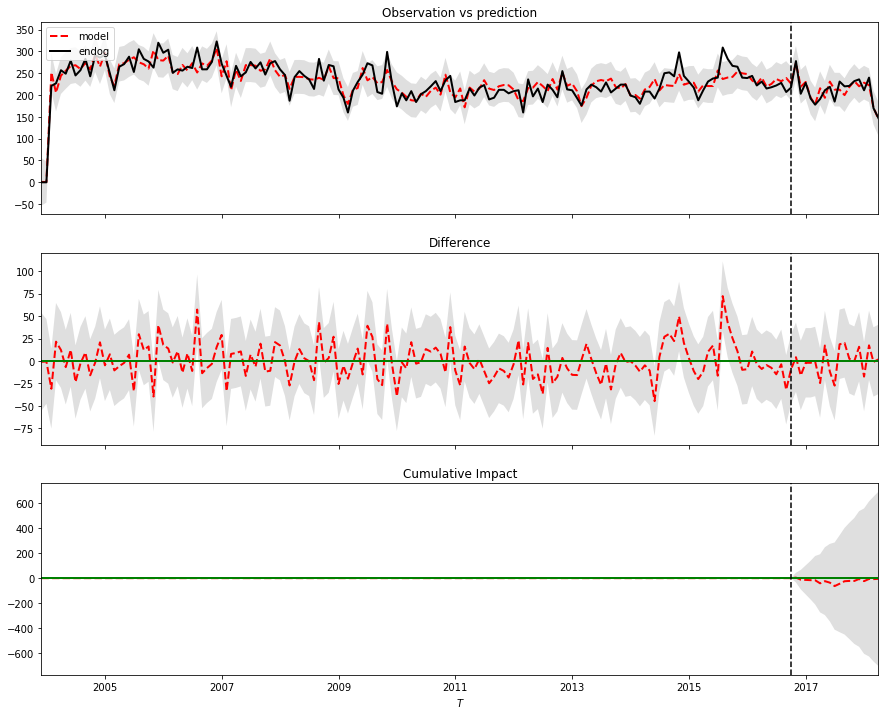

In [42]:
impact_collision_count.plot()

#### Step 4: Analysis of only speeding related collisions

The total count of collision doesn't appear to have been impacted by a change in speed limits in central Seattle, but what about only speeding related collisions? Surely those were affected. 

With lower limits, more drivers might be speeding in general. From this, we could hypothesize that more collisions could be linked to speeding.

First we'll re-pull the filtered data and group by month. We'll plot the data and check the correlation between control and treatment again.

In [43]:
monthly_speeding_count = render_stats.pivot_by_treatment(input_frame=data[data['speeding']=='Y'], treatment_list=speed_limit_nbrhood, control_list=None
                       , neighborhood_path='../wa_collisions/data/Neighborhoods/Neighborhoods.json'
                       , agg_by=None, resample_by='M')

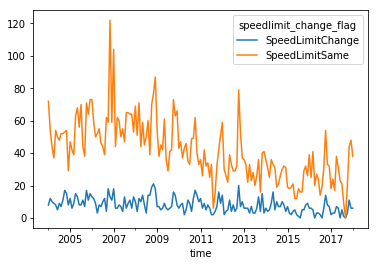

In [44]:
monthly_speeding_count.plot()

In [45]:
monthly_speeding_count.corr()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
speedlimit_change_flag,,
SpeedLimitChange,1.000000,0.665524
SpeedLimitSame,0.665524,1.000000


In [46]:
monthly_speeding_count.ix['2011-10-01':'2016-10-01'].corr()

C:\Users\geoffc.REDMOND\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
speedlimit_change_flag,,
SpeedLimitChange,1.000000,0.665979
SpeedLimitSame,0.665979,1.000000


Interesting. We are not seeing a strong correlation here, and it is basically the same whether we look at all months or just the 5 years before the speed limit change.

What does Causal Impact show?

First, let's make sure our date range are still valid.

In [47]:
date_ranges = render_stats.find_period_ranges(monthly_speeding_count, transition_date="2016-10-01")
print('pre:', date_ranges[0])
print('post:', date_ranges[1])

pre: ['2004-01-31', '2016-09-30']
post: ['2016-10-31', '2018-01-31']


In [48]:
impact_speeding_count = CausalImpact(monthly_speeding_count, date_ranges[0], date_ranges[1])
impact_speeding_count.run()

In [49]:
impact_speeding_count.summary()

                           Average         Cumulative
Actual                           5                 82
Predicted                        5                 94
95% CI                     [0, 12]         [-14, 203]
                                                     
Absolute Effect                  0                -12
95% CI                     [6, -7]         [96, -121]
                                                     
Relative Effect             -13.6%             -13.6%
95% CI           [101.3%, -128.4%]  [101.3%, -128.4%]


We are seeing a drop in the number of speeding collisions predicted, contrary to my hypothesis. Interesting.

Unfortunately, due to the high variability in month collisions in general, we are not able to detect statistical significance. 

Plotting the data below, there is an apparent downward trend in cumulative impact though.

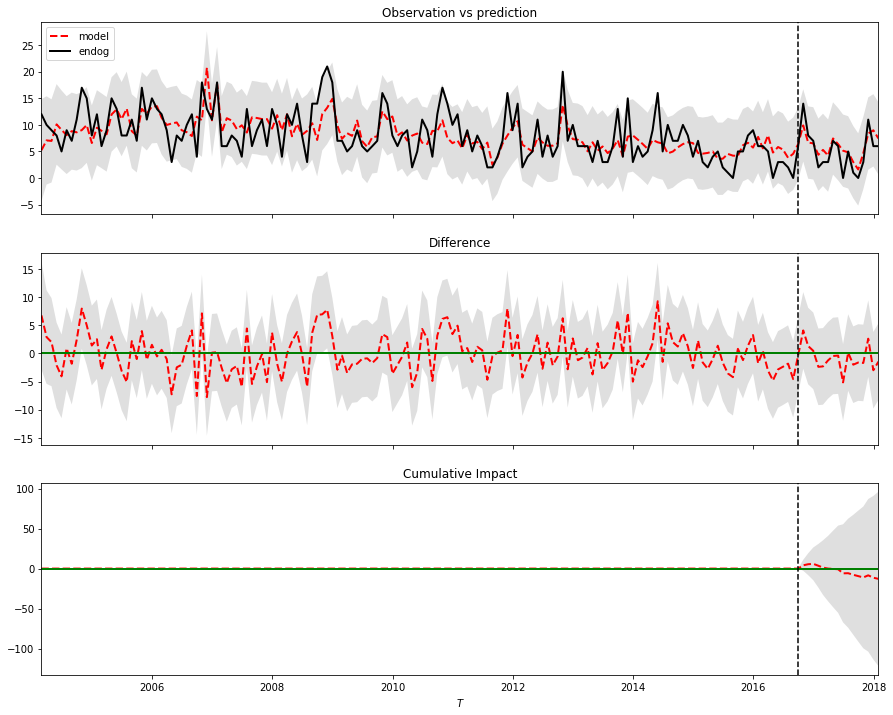

In [50]:
impact_speeding_count.plot()

#### Step 5: Analysis of injuries

So far, we see almost no notable impact of the speed limit changes on collision counts in Seattle, but what about injuries? Perhaps there are just as many fender benders as before but because people are driving slower, fewer people were injured.

First, let's repull the data, plot it and check control/treatment correlation like we did above.

In [51]:
monthly_injuries = render_stats.pivot_by_treatment(input_frame=data, treatment_list=speed_limit_nbrhood, control_list=None
                       , neighborhood_path='../wa_collisions/data/Neighborhoods/Neighborhoods.json'
                       , agg_by='injuries', resample_by='M')

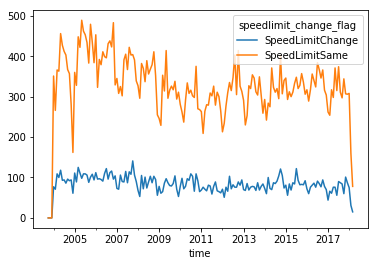

In [52]:
monthly_injuries.plot()

In [53]:
monthly_injuries.corr()

speedlimit_change_flag,SpeedLimitChange,SpeedLimitSame
speedlimit_change_flag,,
SpeedLimitChange,1.000000,0.772163
SpeedLimitSame,0.772163,1.000000


As before, we are seeing a reasonably high correlation between treatment and control, however the plot does not suggest the number of injuries has fallen. 

Let's run it through Causal Impact.

In [54]:
date_ranges = render_stats.find_period_ranges(monthly_injuries, transition_date="2016-10-01")
print('pre:', date_ranges[0])
print('post:', date_ranges[1])

pre: ['2003-10-31', '2016-09-30']
post: ['2016-10-31', '2018-03-31']


In [55]:
impact_injuries = CausalImpact(monthly_injuries, date_ranges[0], date_ranges[1])
impact_injuries.run()

In [56]:
impact_injuries.summary()

                         Average       Cumulative
Actual                        69             1251
Predicted                     77             1391
95% CI                 [50, 103]      [917, 1864]
                                                 
Absolute Effect               -7             -140
95% CI                 [18, -34]      [333, -613]
                                                 
Relative Effect           -10.1%           -10.1%
95% CI           [24.0%, -44.1%]  [24.0%, -44.1%]


We are actually seeing 140 total fewer injuries than might have been predicted. It's not statistically significant, but still an interesting result. Let's see how appararent this is in the plot.

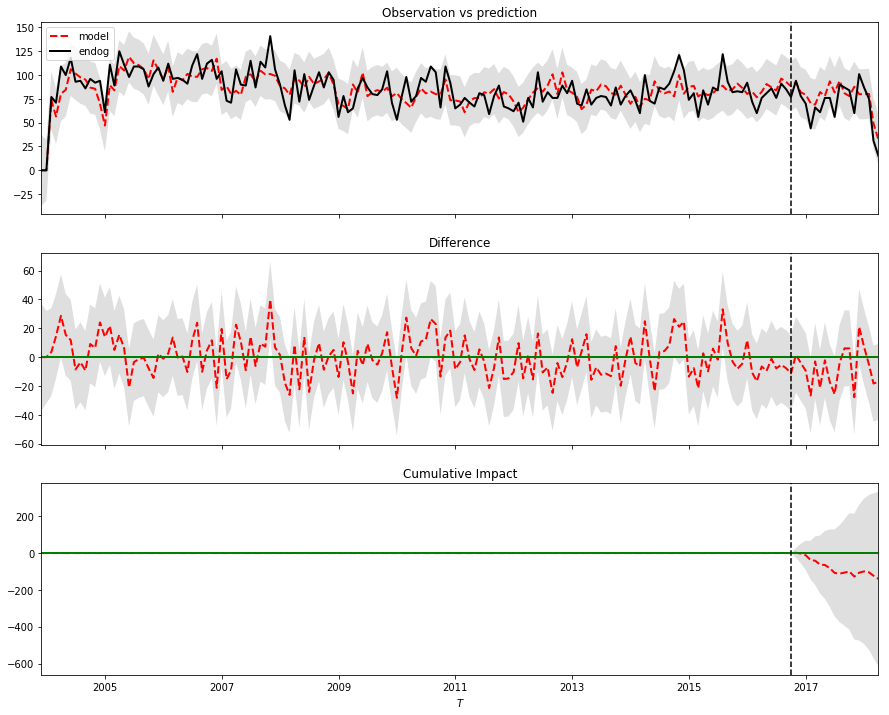

In [57]:
impact_injuries.plot()

We see a definite drop over time in the number of injuries, however the data is too noisy to be able to say definitely.

#### Summary

In this notebook, we have used Causal Impact to analyze collisions in Seattle before and after speed limits were dropped in October of 2016. 

While the speed limit change does not appear to have affected the total number of collisions, it's possible that it had a small impact on reducing speeding related collisions and the number of injuries caused by collisions.

Unfortunately, due to small sizes and an inherently noisy dataset, we are unable to come to any firm conclusions. However, we do see some positive signals. 